<a href="https://colab.research.google.com/github/theresatvan/cs-gy-6613-assignments/blob/main/ttv2006_take_at_home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem 1: Take at Home  (45 points)

### Introduction
Typically when we train a Convolutional Neural Network as an end-to-end image classifier, we input an image to the network, which gets propagated through the network (feed forward).

We then obtain our posterior probabilities at the end of the network.

However, there is no “rule” that says we must allow the image to forward propagate through the entire network that includes the head. Instead, we can:

1) Stop propagation at a layer before the head of the network (such as an activation or pooling layer).

2) Extract the logits at this layer.

3) Treat the values as a feature vector.

Now these feature vectors can be utilized in other downstream tasks like classification. Our aim is to create a system where an input query image will be responded by a number of  images that have strong resemblance to the query image. This particular task is called **similarity search**. A naive way to perform this task, would be to compare images based on pixel values, patches, or some other high level feature taken from the image itself. You are askd to use the ResNet-50 architecture to produce features that can represent a concept aka a face with specific characteristics. 

### Part 1 Loading of Dataset in Colab (5 points)

Create a jupyter notebook (eg on Google Colab) and download the LFW dataset, from [here](http://vis-www.cs.umass.edu/lfw/).

You can manually download the dataset using the above link and then upload to colab or altelnatively you can issue in colab the commands shown below


In [ ]:
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
! tar -xvf /content/lfw.tgz

### Part 2 Using CNN for Feature Extraction (25 points)

Use ResNet50 to extract features vectors from raw images. You can use TF or Pytorch APIs to: 

* Obtain a ResNet-50  model pre-trained on a dataset such as ImageNet. 
* Perform necessary preprocessing on the images before feeding them into the network.
* Extract the features from the penultimate layer of the network (before the fully connected layer - the classification head).
* Store the features in a dictionary, where the key is the name of the image and the value is the feature vector.


In [2]:
# import all necessary packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from glob import glob
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from sklearn.neighbors import NearestNeighbors


In [3]:
# retrieve ResNet-50 model pretrained on ImageNet
model = ResNet50(weights='imagenet', include_top=False, pooling="avg")

94765736/94765736 [==============================] - 1s 0us/step


In [4]:
# load image dataset from directory and resize for ResNet50 model
dataset = image_dataset_from_directory('/content/lfw/', image_size=(224, 224), batch_size=1)

Found 13233 files belonging to 5749 classes.


In [5]:
# rescale the dataset for preprocessing
rescale = Rescaling(scale=1./255)

inputs = dataset.map(lambda x, y: (rescale(x), y))
inputs = dataset.map(lambda x, y: (preprocess_input(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
#store all image names and their corresponding feature vector into a dictionary
features = {}
filenames = dataset.file_paths

for i, (x, y) in enumerate(inputs):
  features_vector = model.predict(x)
  features[os.path.basename(filenames[i])] = features_vector
  print(i)

### Part 3 Retrieving most similar images (15 points)

Use a nearest neighbor algorithm such as [this](https://scikit-learn.org/stable/modules/neighbors.html) to obtain the 10 most similar images to 5 query images of your choice. Choose the results that best illustrate the effectiveness of your system. 


In [8]:
# convert all feature vectors into a single data matrix
df = np.row_stack(features.values())

# obtain k nearest neighbors model
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(df)


<ipython-input-8-a14061ce3e17>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  df = np.row_stack(features.values())


NearestNeighbors(metric='euclidean', n_neighbors=10)

In [9]:
def similar_images(indices, distances):
  # display k nearest neighbors in order of ascending distance
  
  fig=plt.figure(figsize=(15,10), facecolor='white')
  plotnumber = 1 

  for index in indices:
    if plotnumber <= len(indices):
      ax = plt.subplot(3,5,plotnumber)
      ax.set_title(os.path.basename(filenames[index]) + '\n Rank: ' + (str)(plotnumber), fontsize=11)
      plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
      plt.xlabel('dis: ' + (str)(distances[0][plotnumber-1]), fontsize=10)

      plotnumber+=1
            
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.7)

In [10]:
def query_images(img_path):
  # extracts feature vector of queried image and finds k nearest neighbors

  img = load_img(img_path, target_size=(224, 224))
  img_array = img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)

  test_img_features = model.predict(preprocessed_img, batch_size=1)
  distances, indices = knn.kneighbors(test_img_features, n_neighbors=10, return_distance=True)

  fig, ax = plt.subplots()
  ax.imshow(mpimg.imread(img_path), interpolation='none')
  ax.set_title(os.path.basename(img_path))
  plt.show()

  similar_images(indices[0], distances)

1/1 [==============================] - 0s 212ms/step


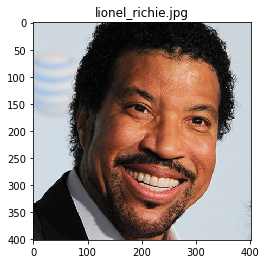

1/1 [==============================] - 0s 235ms/step


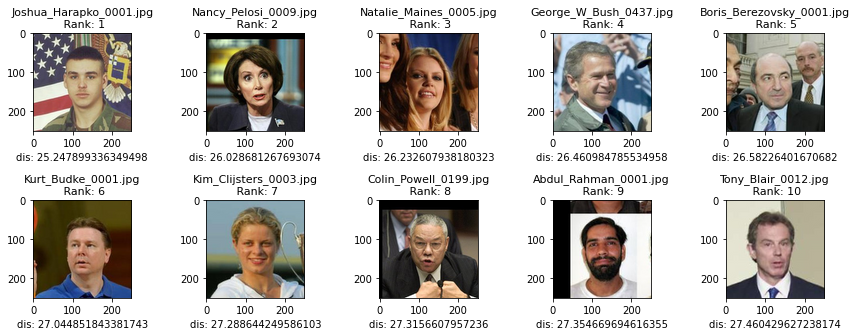

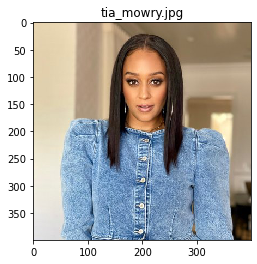

1/1 [==============================] - 0s 228ms/step


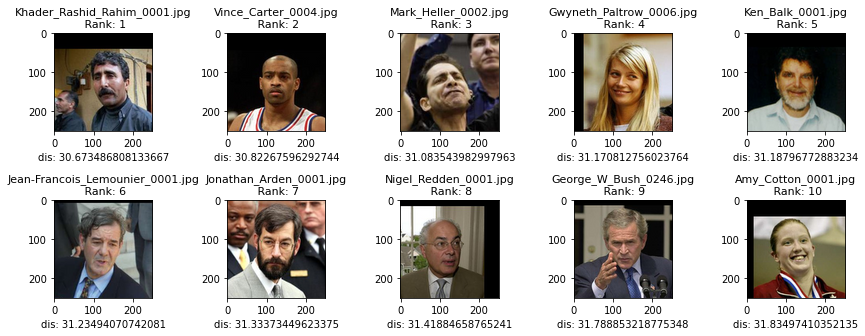

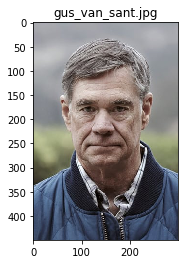

1/1 [==============================] - 0s 370ms/step


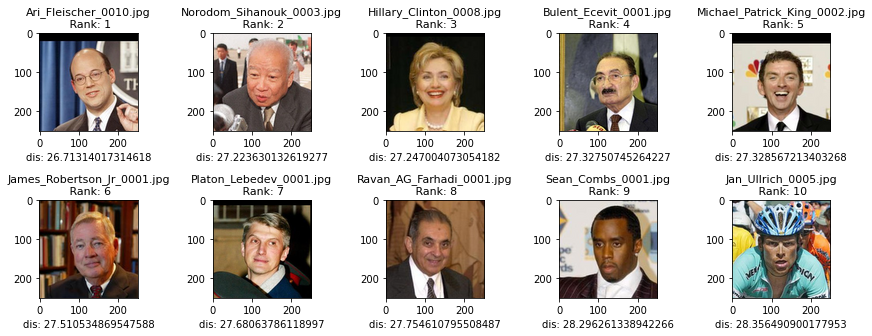

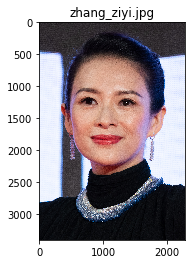

1/1 [==============================] - 0s 222ms/step


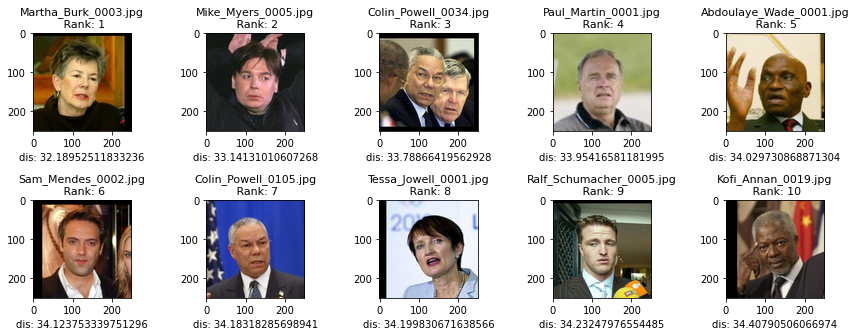

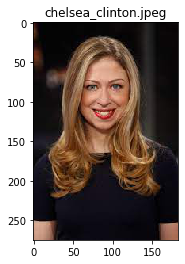

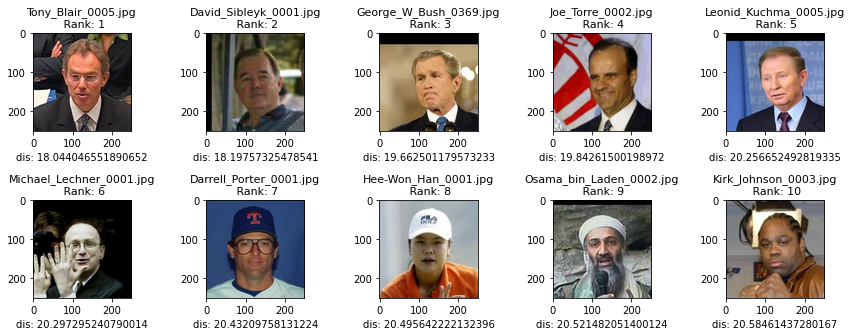

In [12]:
# find 10 most similar images for 5 query images

query_path = "/content/query_images/*"
for files in glob(query_path):
  query_images(files)